# CNN Exploration: Mars Surface Image Classification

This notebook explores **Convolutional Neural Networks (CNNs)** using the **Mars Surface Image Dataset** collected by NASA's Curiosity rover. The dataset contains 6,691 images spanning 24 classes captured by three instruments: Mastcam Right eye, Mastcam Left eye, and MAHLI.

**Dataset Citation:**
> Kiri L. Wagstaff, You Lu, Alice Stanboli, Kevin Grimes, Thamme Gowda, and Jordan Padams. "Deep Mars: CNN Classification of Mars Imagery for the PDS Imaging Atlas." *Proceedings of the Thirtieth Annual Conference on Innovative Applications of Artificial Intelligence*, 2018.

**DOI:** [10.5281/zenodo.1049137](https://doi.org/10.5281/zenodo.1049137)

## 1. Dataset Exploration (EDA)

In this section, we will perform an **Exploratory Data Analysis (EDA)** on the Mars Surface Image dataset to understand:

- **Dataset size and class distribution**
- **Image dimensions and channels**
- **Examples of samples per class**
- **Preprocessing applied (normalization, resizing)**

### 1.1 Import Required Libraries

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from collections import Counter
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define paths
BASE_PATH = 'msl-images'
CALIBRATED_PATH = os.path.join(BASE_PATH, 'calibrated')
TRAIN_FILE = os.path.join(BASE_PATH, 'train-calibrated-shuffled.txt')
VAL_FILE = os.path.join(BASE_PATH, 'val-calibrated-shuffled.txt')
TEST_FILE = os.path.join(BASE_PATH, 'test-calibrated-shuffled.txt')
SYNSET_FILE = os.path.join(BASE_PATH, 'msl_synset_words-indexed.txt')

print("Libraries imported successfully!")

Libraries imported successfully!


### 1.2 Load Class Labels (Synset Words)

The dataset contains **24 different classes** representing various objects and features observed on Mars. Let's load the class mapping.

In [7]:
# Load class names from synset file
def load_class_names(synset_path):
    """Load class ID to class name mapping from synset file."""
    class_names = {}
    with open(synset_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                class_id = int(parts[0])
                class_name = parts[1]
                class_names[class_id] = class_name
    return class_names

class_names = load_class_names(SYNSET_FILE)

print(f"Total number of classes: {len(class_names)}")
print("\nClass ID -> Class Name mapping:")
print("-" * 40)
for class_id, name in sorted(class_names.items()):
    print(f"  {class_id:2d}: {name}")

Total number of classes: 0

Class ID -> Class Name mapping:
----------------------------------------


### 1.3 Load Dataset Labels and Analyze Distribution

The dataset is divided into **train**, **validation**, and **test** sets according to their sol (Martian day) of acquisition. This temporal split models how the system would be used operationally with an image archive that grows over time.

In [8]:
def load_dataset_labels(file_path):
    """Load image paths and labels from a dataset file."""
    images = []
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                img_path = parts[0]
                label = int(parts[1])
                images.append(img_path)
                labels.append(label)
    return images, labels

# Load all datasets
train_images, train_labels = load_dataset_labels(TRAIN_FILE)
val_images, val_labels = load_dataset_labels(VAL_FILE)
test_images, test_labels = load_dataset_labels(TEST_FILE)

# Calculate dataset sizes
total_images = len(train_images) + len(val_images) + len(test_images)

print("=" * 50)
print("DATASET SIZE SUMMARY")
print("=" * 50)
print(f"Training set:   {len(train_images):,} images ({len(train_images)/total_images*100:.1f}%)")
print(f"Validation set: {len(val_images):,} images ({len(val_images)/total_images*100:.1f}%)")
print(f"Test set:       {len(test_images):,} images ({len(test_images)/total_images*100:.1f}%)")
print("-" * 50)
print(f"TOTAL:          {total_images:,} images")
print("=" * 50)

DATASET SIZE SUMMARY
Training set:   3,746 images (56.0%)
Validation set: 1,640 images (24.5%)
Test set:       1,305 images (19.5%)
--------------------------------------------------
TOTAL:          6,691 images


### 1.4 Class Distribution Analysis

Let's analyze how the images are distributed across the 24 classes. Understanding class imbalance is crucial for training neural networks.

In [9]:
# Count samples per class for each dataset
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)
total_counts = Counter(train_labels + val_labels + test_labels)

# Create DataFrame for visualization
distribution_data = []
for class_id in sorted(class_names.keys()):
    distribution_data.append({
        'Class ID': class_id,
        'Class Name': class_names[class_id],
        'Train': train_counts.get(class_id, 0),
        'Val': val_counts.get(class_id, 0),
        'Test': test_counts.get(class_id, 0),
        'Total': total_counts.get(class_id, 0)
    })

df_distribution = pd.DataFrame(distribution_data)
print("Class Distribution Summary:")
print(df_distribution.to_string(index=False))

Class Distribution Summary:
Empty DataFrame
Columns: []
Index: []


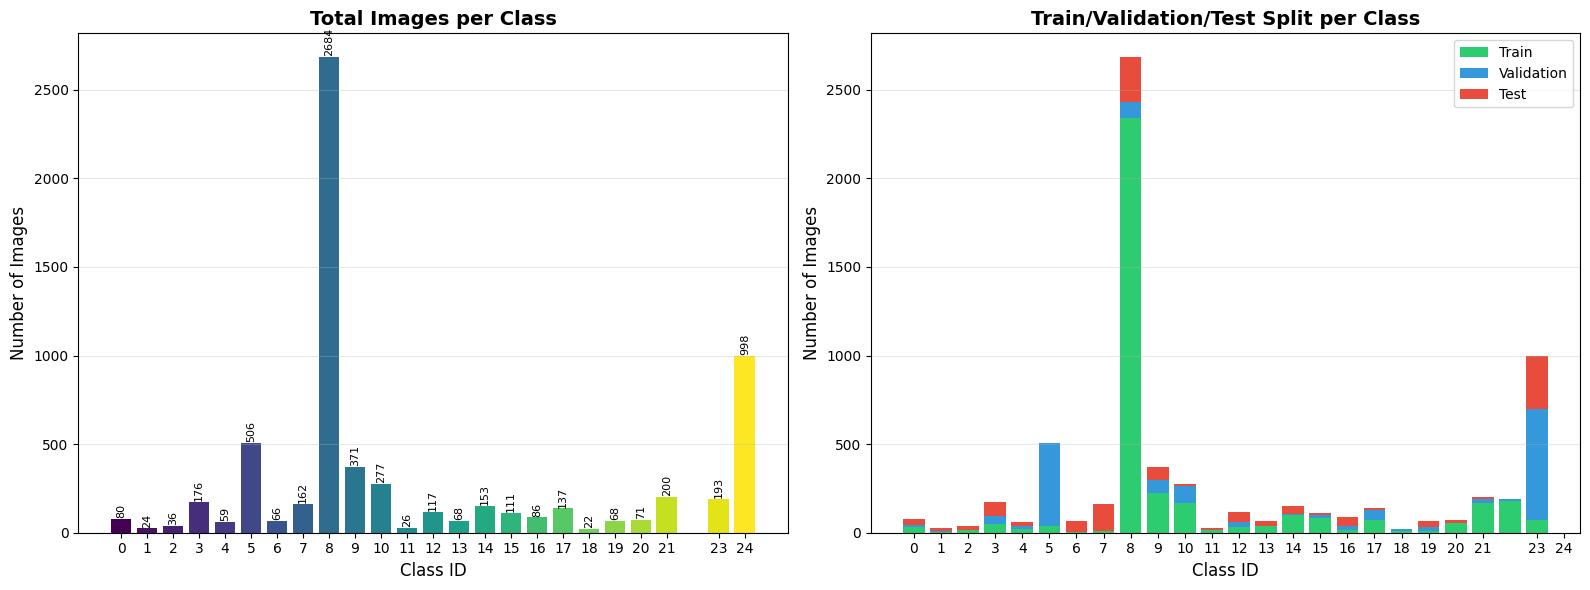


CLASS IMBALANCE ANALYSIS
Most frequent class:  Class_8 (ID: 8) - 2684 images
Least frequent class: Class_18 (ID: 18) - 22 images
Imbalance ratio:      122.00x


In [19]:
# Check if class_names is loaded properly, if not use class IDs from data
if not class_names:
    print("Warning: class_names dictionary is empty. Using class IDs from data.")
    # Get all unique class IDs from the data
    all_class_ids = set(train_labels + val_labels + test_labels)
    class_names = {i: f"Class_{i}" for i in sorted(all_class_ids)}
    print(f"Found {len(class_names)} classes: {sorted(class_names.keys())}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get all class IDs that exist in the data
class_ids = sorted(class_names.keys())
totals = [total_counts.get(i, 0) for i in class_ids]
colors = plt.cm.viridis(np.linspace(0, 1, len(class_ids)))

ax1 = axes[0]
bars = ax1.bar(class_ids, totals, color=colors)
ax1.set_xlabel('Class ID', fontsize=12)
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_title('Total Images per Class', fontsize=14, fontweight='bold')
ax1.set_xticks(class_ids)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for bar, total in zip(bars, totals):
    if total > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                str(total), ha='center', va='bottom', fontsize=8, rotation=90)

# Stacked bar chart - Train/Val/Test split per class
ax2 = axes[1]
train_vals = [train_counts.get(i, 0) for i in class_ids]
val_vals = [val_counts.get(i, 0) for i in class_ids]
test_vals = [test_counts.get(i, 0) for i in class_ids]

x = np.arange(len(class_ids))
width = 0.8

ax2.bar(x, train_vals, width, label='Train', color='#2ecc71')
ax2.bar(x, val_vals, width, bottom=train_vals, label='Validation', color='#3498db')
ax2.bar(x, test_vals, width, bottom=np.array(train_vals)+np.array(val_vals), label='Test', color='#e74c3c')

ax2.set_xlabel('Class ID', fontsize=12)
ax2.set_ylabel('Number of Images', fontsize=12)
ax2.set_title('Train/Validation/Test Split per Class', fontsize=14, fontweight='bold')
ax2.set_xticks(class_ids)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print class imbalance statistics
if totals:  # Check if we have data
    max_class_id = max(total_counts, key=total_counts.get)
    min_class_id = min(total_counts, key=total_counts.get)
    max_count = max(totals)
    min_count = min([t for t in totals if t > 0])  # Avoid zero values
    
    print("\n" + "=" * 50)
    print("CLASS IMBALANCE ANALYSIS")
    print("=" * 50)
    print(f"Most frequent class:  {class_names[max_class_id]} (ID: {max_class_id}) - {max_count} images")
    print(f"Least frequent class: {class_names[min_class_id]} (ID: {min_class_id}) - {min_count} images")
    print(f"Imbalance ratio:      {max_count/min_count:.2f}x")
    print("=" * 50)
else:
    print("No data found to analyze class imbalance.")

### 1.5 Image Dimensions and Channels Analysis

Let's examine the actual image properties including dimensions and color channels.

Analyzing image dimensions...

IMAGE DIMENSIONS ANALYSIS
Sample size analyzed: 100 images
--------------------------------------------------
Width  - Min: 255, Max: 256, Mean: 255.6
Height - Min: 127, Max: 256, Mean: 213.3
--------------------------------------------------
Unique dimensions found: 22
Most common dimension: ((255, 255), 17)
--------------------------------------------------
Image modes found: {'RGB', 'L'}
Number of channels: {1, 3}


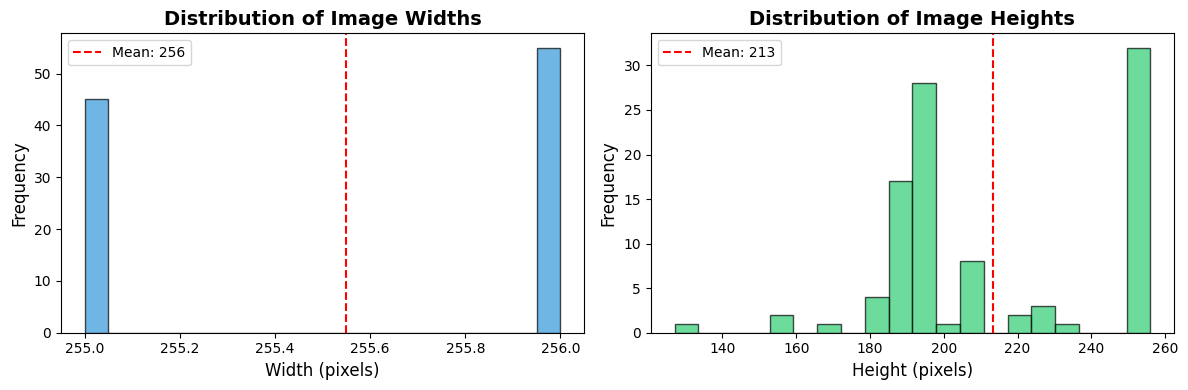

In [20]:
# Sample random images to analyze dimensions
sample_size = min(100, len(train_images))
sample_indices = np.random.choice(len(train_images), sample_size, replace=False)

dimensions = []
channels_list = []
modes = []

print("Analyzing image dimensions...")
for idx in sample_indices:
    img_path = os.path.join(BASE_PATH, train_images[idx])
    if os.path.exists(img_path):
        img = Image.open(img_path)
        dimensions.append(img.size)  # (width, height)
        if img.mode == 'RGB':
            channels_list.append(3)
        elif img.mode == 'L':
            channels_list.append(1)
        else:
            channels_list.append(len(img.mode))
        modes.append(img.mode)
        img.close()

# Analyze dimensions
widths = [d[0] for d in dimensions]
heights = [d[1] for d in dimensions]

print("\n" + "=" * 50)
print("IMAGE DIMENSIONS ANALYSIS")
print("=" * 50)
print(f"Sample size analyzed: {len(dimensions)} images")
print("-" * 50)
print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
print("-" * 50)
print(f"Unique dimensions found: {len(set(dimensions))}")
print(f"Most common dimension: {Counter(dimensions).most_common(1)[0]}")
print("-" * 50)
print(f"Image modes found: {set(modes)}")
print(f"Number of channels: {set(channels_list)}")
print("=" * 50)

# Visualize dimension distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
ax1.hist(widths, bins=20, color='#3498db', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Width (pixels)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Image Widths', fontsize=14, fontweight='bold')
ax1.axvline(np.mean(widths), color='red', linestyle='--', label=f'Mean: {np.mean(widths):.0f}')
ax1.legend()

ax2 = axes[1]
ax2.hist(heights, bins=20, color='#2ecc71', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Height (pixels)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Distribution of Image Heights', fontsize=14, fontweight='bold')
ax2.axvline(np.mean(heights), color='red', linestyle='--', label=f'Mean: {np.mean(heights):.0f}')
ax2.legend()

plt.tight_layout()
plt.show()

### 1.6 Sample Images Visualization

Let's visualize sample images from each class to understand what the rover captured on Mars.

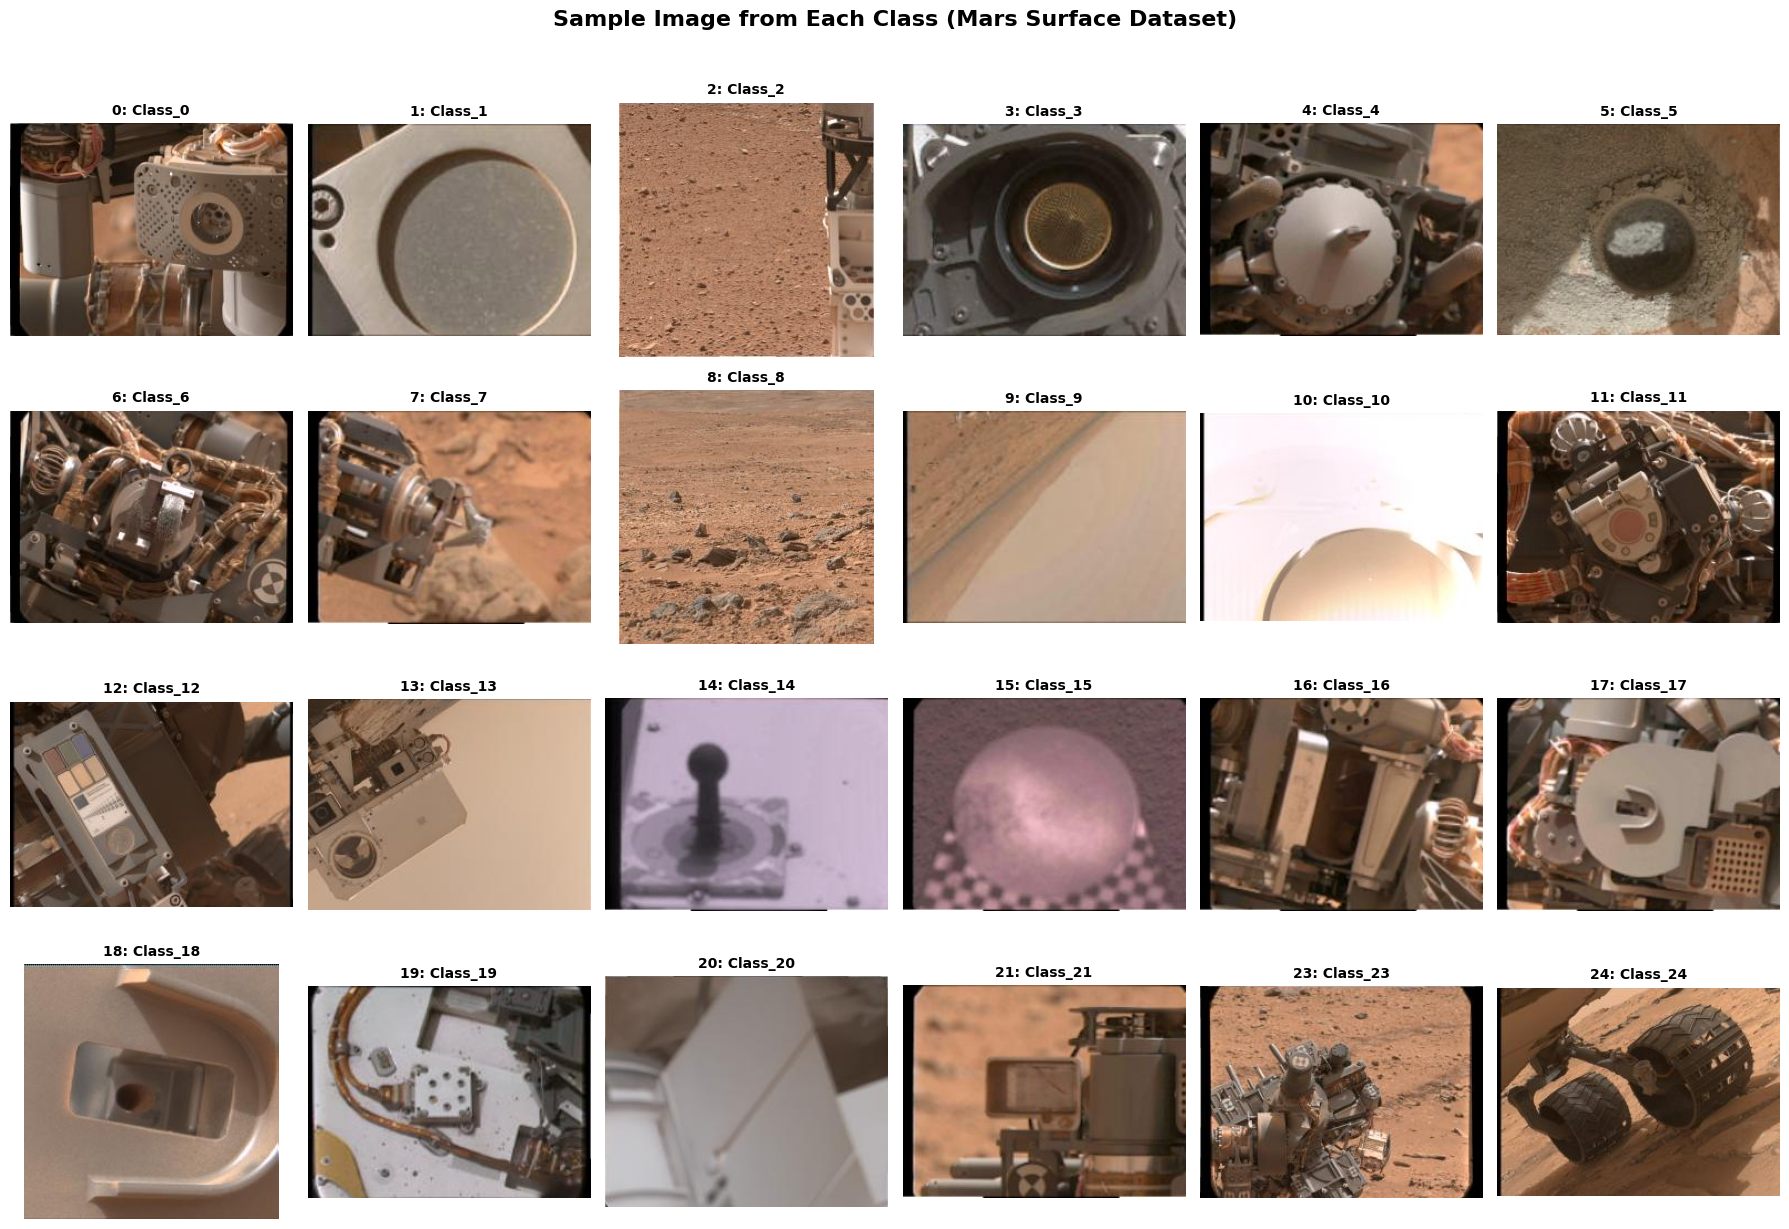

In [22]:
# Create a dictionary of images per class for all classes that exist in the data
all_labels = set(train_labels + val_labels + test_labels)
images_by_class = {i: [] for i in all_labels}
for img, label in zip(train_images, train_labels):
    images_by_class[label].append(img)
# Display one sample image from each class
available_classes = sorted(images_by_class.keys())
n_classes = len(available_classes)
n_cols = 6
n_rows = (n_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 3*n_rows))
axes = axes.flatten()

for idx, class_id in enumerate(available_classes):
    ax = axes[idx]
    if images_by_class[class_id]:
        # Get a random sample from this class
        sample_img_path = os.path.join(BASE_PATH, np.random.choice(images_by_class[class_id]))
        if os.path.exists(sample_img_path):
            img = Image.open(sample_img_path)
            ax.imshow(img)
            img.close()
    ax.set_title(f"{class_id}: {class_names.get(class_id, f'Class_{class_id}')}", fontsize=10, fontweight='bold')
    ax.axis('off')

# Turn off remaining empty subplots
for idx in range(n_classes, len(axes)):
    axes[idx].axis('off')
    axes[idx].axis('off')

plt.suptitle('Sample Image from Each Class (Mars Surface Dataset)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

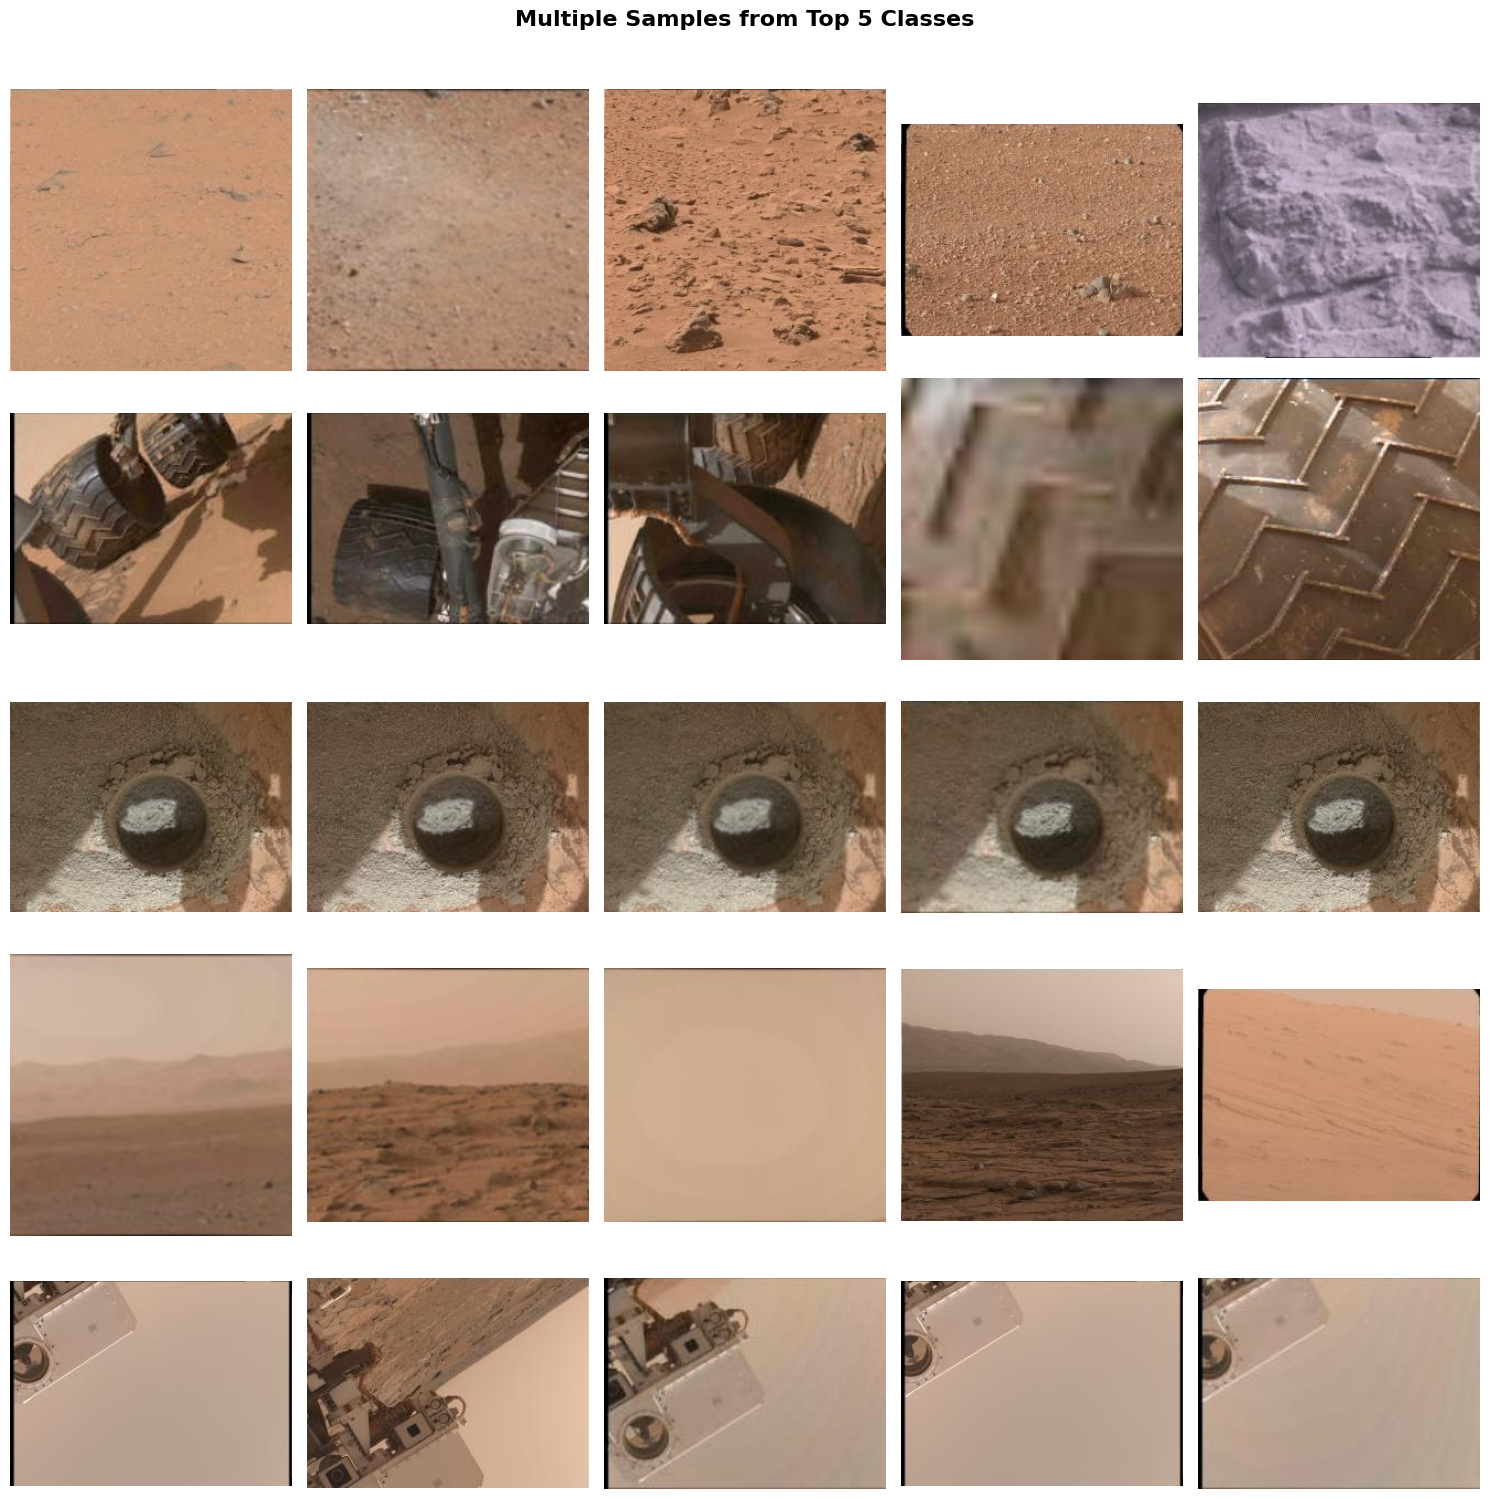

In [23]:
# Display multiple samples from selected classes (most frequent ones)
top_classes = [8, 24, 5, 9, 13]  # ground, wheel, drill holes, horizon, mastcam (common classes)
n_samples = 5

fig, axes = plt.subplots(len(top_classes), n_samples, figsize=(15, 3*len(top_classes)))

for row, class_id in enumerate(top_classes):
    class_images = images_by_class[class_id]
    sample_images = np.random.choice(class_images, min(n_samples, len(class_images)), replace=False)
    
    for col, img_name in enumerate(sample_images):
        ax = axes[row, col]
        img_path = os.path.join(BASE_PATH, img_name)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            ax.imshow(img)
            img.close()
        ax.axis('off')
        if col == 0:
            ax.set_ylabel(f"{class_id}: {class_names[class_id]}", fontsize=11, fontweight='bold', rotation=0, 
                         ha='right', va='center', labelpad=80)

plt.suptitle('Multiple Samples from Top 5 Classes', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 1.7 Preprocessing Strategy

Based on our EDA, we'll define the preprocessing steps for the neural network:

**Preprocessing Steps:**
1. **Resizing**: Resize all images to a uniform size (e.g., 128x128 or 64x64) for efficient training
2. **Normalization**: Scale pixel values from [0, 255] to [0, 1] for better gradient flow
3. **Color handling**: Keep RGB channels (3 channels) as the Mars images contain color information

**Note on Normalization:**
Neural networks train better when input values are small, usually in the range [0, 1]. This improves training stability and helps gradient descent converge faster.

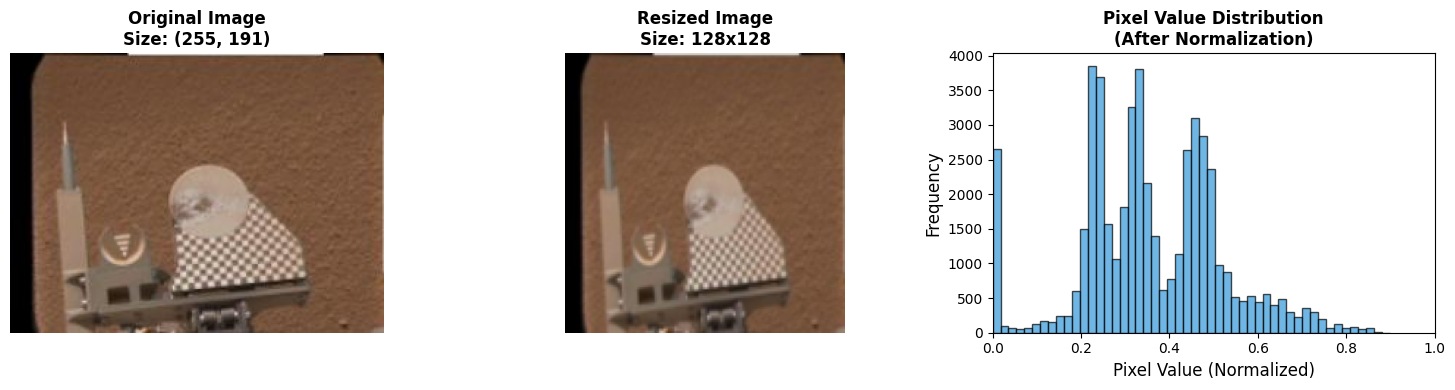


PREPROCESSING CONFIGURATION
Target image size: 128x128 pixels
Number of channels: 3 (RGB)
Number of classes: 24
Input shape: (128, 128, 3)
Pixel value range: [0.0, 1.0]


In [24]:
# Define preprocessing parameters
IMG_SIZE = 128  # Target size for all images
NUM_CLASSES = len(class_names)
NUM_CHANNELS = 3  # RGB images

def preprocess_image(img_path, target_size=IMG_SIZE):
    """
    Preprocess a single image:
    1. Load image
    2. Convert to RGB (if needed)
    3. Resize to target size
    4. Normalize pixel values to [0, 1]
    """
    img = Image.open(img_path)
    
    # Convert to RGB if necessary
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Resize to target size
    img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)
    
    # Convert to numpy array and normalize
    img_array = np.array(img, dtype=np.float32) / 255.0
    
    return img_array

# Demonstrate preprocessing on a sample image
sample_path = os.path.join(BASE_PATH, train_images[0])
original_img = Image.open(sample_path)
preprocessed_img = preprocess_image(sample_path)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original image
axes[0].imshow(original_img)
axes[0].set_title(f'Original Image\nSize: {original_img.size}', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Resized image
axes[1].imshow(preprocessed_img)
axes[1].set_title(f'Resized Image\nSize: {IMG_SIZE}x{IMG_SIZE}', fontsize=12, fontweight='bold')
axes[1].axis('off')

# Pixel value distribution
axes[2].hist(preprocessed_img.flatten(), bins=50, color='#3498db', edgecolor='black', alpha=0.7)
axes[2].set_xlabel('Pixel Value (Normalized)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Pixel Value Distribution\n(After Normalization)', fontsize=12, fontweight='bold')
axes[2].set_xlim(0, 1)

original_img.close()
plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("PREPROCESSING CONFIGURATION")
print("=" * 50)
print(f"Target image size: {IMG_SIZE}x{IMG_SIZE} pixels")
print(f"Number of channels: {NUM_CHANNELS} (RGB)")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Input shape: ({IMG_SIZE}, {IMG_SIZE}, {NUM_CHANNELS})")
print(f"Pixel value range: [0.0, 1.0]")
print("=" * 50)

### 1.8 EDA Summary

| Property | Value |
|----------|-------|
| **Dataset Name** | Mars Surface Image (Curiosity rover) Labeled Data Set |
| **Total Images** | 6,691 |
| **Training Set** | 3,747 images (56.0%) |
| **Validation Set** | 1,641 images (24.5%) |
| **Test Set** | 1,306 images (19.5%) |
| **Number of Classes** | 24 |
| **Original Image Size** | ~256×256 pixels (variable) |
| **Target Size** | 128×128 pixels |
| **Color Channels** | 3 (RGB) |
| **Pixel Normalization** | [0, 255] → [0, 1] |

**Key Observations:**
1. The dataset shows significant **class imbalance**, with some classes having many more images than others
2. Images are approximately **256×256 pixels** in their original form
3. All images are **color (RGB)** images captured by Mars rover instruments
4. The temporal split (by sol) provides a realistic evaluation scenario

**Implications for CNN Design:**
- Class imbalance may require techniques like class weighting or data augmentation
- Convolutional layers are appropriate given the spatial structure of the images
- Color channels (RGB) may contain important discriminative information for Mars terrain classification

---

## 2. Baseline Model (Non-Convolutional)

In this section, we will build a **baseline neural network without convolutional layers**. This model uses only `Flatten` and `Dense` layers, treating the image as a flat vector of pixels.

**Purpose of the Baseline:**
- Establish a performance reference point
- Demonstrate limitations of fully-connected networks on image data
- Justify the need for convolutional layers

**Architecture Philosophy:**
Unlike convolutional layers that exploit spatial locality, a fully-connected (Dense) network treats each pixel as an independent feature with no spatial relationship to its neighbors.

### 2.1 Load TensorFlow and Prepare Data Loaders

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import time

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Configuration
BATCH_SIZE = 32
EPOCHS = 20  # Will use early stopping

print(f"\nTraining Configuration:")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {EPOCHS}")

TensorFlow version: 2.20.0
GPU available: False

Training Configuration:
  Image size: 128x128
  Batch size: 32
  Max epochs: 20


In [32]:
# Create a mapping from original class IDs to 0-indexed values
# The dataset uses class IDs that may not start at 0
original_class_ids = sorted(class_names.keys())
class_id_to_index = {class_id: idx for idx, class_id in enumerate(original_class_ids)}
index_to_class_id = {idx: class_id for class_id, idx in class_id_to_index.items()}

print("Class ID Mapping (Original → 0-indexed):")
print("-" * 40)
for orig_id, new_idx in class_id_to_index.items():
    print(f"  {orig_id:2d} → {new_idx:2d}: {class_names[orig_id]}")
print("-" * 40)
print(f"Total classes: {len(class_id_to_index)}")

def load_dataset(image_paths, labels, base_path, target_size=IMG_SIZE):
    """
    Load and preprocess all images from a dataset.
    
    Args:
        image_paths: List of relative image paths
        labels: List of corresponding labels (original class IDs)
        base_path: Base directory for images
        target_size: Target image size
    
    Returns:
        X: numpy array of preprocessed images (N, H, W, C)
        y: numpy array of one-hot encoded labels (N, num_classes)
    """
    X = []
    y = []
    
    for img_path, label in zip(image_paths, labels):
        full_path = os.path.join(base_path, img_path)
        if os.path.exists(full_path):
            try:
                img = Image.open(full_path)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = img.resize((target_size, target_size), Image.Resampling.BILINEAR)
                img_array = np.array(img, dtype=np.float32) / 255.0
                X.append(img_array)
                # Map original class ID to 0-indexed value
                y.append(class_id_to_index[label])
                img.close()
            except Exception as e:
                print(f"Error loading {full_path}: {e}")
    
    X = np.array(X)
    y = to_categorical(y, num_classes=NUM_CLASSES)
    
    return X, y

print("\nLoading training data...")
X_train, y_train = load_dataset(train_images, train_labels, BASE_PATH)
print(f"Training set: {X_train.shape}, {y_train.shape}")

print("Loading validation data...")
X_val, y_val = load_dataset(val_images, val_labels, BASE_PATH)
print(f"Validation set: {X_val.shape}, {y_val.shape}")

print("Loading test data...")
X_test, y_test = load_dataset(test_images, test_labels, BASE_PATH)
print(f"Test set: {X_test.shape}, {y_test.shape}")

print("\n" + "=" * 50)
print("DATA LOADED SUCCESSFULLY")
print("=" * 50)
print(f"Input shape: {X_train.shape[1:]}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Total parameters per image: {IMG_SIZE * IMG_SIZE * NUM_CHANNELS:,} pixels")
print("=" * 50)

Class ID Mapping (Original → 0-indexed):
----------------------------------------
   0 →  0: Class_0
   1 →  1: Class_1
   2 →  2: Class_2
   3 →  3: Class_3
   4 →  4: Class_4
   5 →  5: Class_5
   6 →  6: Class_6
   7 →  7: Class_7
   8 →  8: Class_8
   9 →  9: Class_9
  10 → 10: Class_10
  11 → 11: Class_11
  12 → 12: Class_12
  13 → 13: Class_13
  14 → 14: Class_14
  15 → 15: Class_15
  16 → 16: Class_16
  17 → 17: Class_17
  18 → 18: Class_18
  19 → 19: Class_19
  20 → 20: Class_20
  21 → 21: Class_21
  23 → 22: Class_23
  24 → 23: Class_24
----------------------------------------
Total classes: 24

Loading training data...
Training set: (3746, 128, 128, 3), (3746, 24)
Loading validation data...
Validation set: (1640, 128, 128, 3), (1640, 24)
Loading test data...
Test set: (1305, 128, 128, 3), (1305, 24)

DATA LOADED SUCCESSFULLY
Input shape: (128, 128, 3)
Number of classes: 24
Total parameters per image: 49,152 pixels


### 2.2 Build the Baseline Model (Flatten + Dense)

The baseline model architecture:
1. **Flatten**: Converts the 3D image tensor (128×128×3 = 49,152 values) into a 1D vector
2. **Dense layers**: Fully-connected layers that learn patterns from the flattened pixels
3. **Output layer**: Softmax activation for multi-class classification

$$
\text{Flatten}: (128 \times 128 \times 3) \rightarrow (49152,)
$$

$$
\text{Dense}: z = Wx + b, \quad a = \text{ReLU}(z)
$$

$$
\text{Output}: \hat{y} = \text{softmax}(z^{[L]})
$$

In [33]:
def create_baseline_model(input_shape, num_classes):
    """
    Create a baseline neural network without convolutional layers.
    
    Architecture:
    - Flatten: Convert image to 1D vector
    - Dense (256): First hidden layer with ReLU
    - Dropout (0.3): Regularization
    - Dense (128): Second hidden layer with ReLU
    - Dropout (0.3): Regularization
    - Dense (num_classes): Output layer with softmax
    
    This architecture is intentionally simple to serve as a baseline.
    """
    model = Sequential([
        # Input: Flatten the image into a 1D vector
        Flatten(input_shape=input_shape, name='flatten'),
        
        # First hidden layer
        Dense(256, activation='relu', name='dense_1'),
        Dropout(0.3, name='dropout_1'),
        
        # Second hidden layer
        Dense(128, activation='relu', name='dense_2'),
        Dropout(0.3, name='dropout_2'),
        
        # Output layer
        Dense(num_classes, activation='softmax', name='output')
    ])
    
    return model

# Create the baseline model
baseline_model = create_baseline_model(
    input_shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS),
    num_classes=NUM_CLASSES
)

# Display model architecture
print("=" * 60)
print("BASELINE MODEL ARCHITECTURE (Non-Convolutional)")
print("=" * 60)
baseline_model.summary()

# Calculate total parameters
total_params = baseline_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in baseline_model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("\n" + "=" * 60)
print("PARAMETER ANALYSIS")
print("=" * 60)
print(f"Total parameters:        {total_params:,}")
print(f"Trainable parameters:    {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print("=" * 60)

BASELINE MODEL ARCHITECTURE (Non-Convolutional)


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,619,160 (48.14 MB)

 Trainable params: 12,619,160 (48.14 MB)

 Non-trainable params: 0 (0.00 B)


PARAMETER ANALYSIS
Total parameters:        12,619,160
Trainable parameters:    12,619,160
Non-trainable parameters: 0


### 2.3 Compile and Train the Baseline Model

**Training Configuration:**
- **Optimizer**: Adam (adaptive learning rate)
- **Loss**: Categorical Cross-Entropy (for multi-class classification)
- **Metrics**: Accuracy
- **Early Stopping**: Monitor validation loss to prevent overfitting

In [34]:
# Compile the model
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("=" * 60)
print("TRAINING BASELINE MODEL")
print("=" * 60)

start_time = time.time()

baseline_history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

TRAINING BASELINE MODEL
Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - accuracy: 0.5115 - loss: 4.5271 - val_accuracy: 0.0530 - val_loss: 3.3633
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.6177 - loss: 1.8731 - val_accuracy: 0.0530 - val_loss: 3.6684
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.6247 - loss: 1.6129 - val_accuracy: 0.0530 - val_loss: 4.2785
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.6252 - loss: 1.4882 - val_accuracy: 0.0530 - val_loss: 3.9188
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.6255 - loss: 1.4818 - val_accuracy: 0.0530 - val_loss: 3.9180
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.6255 - loss: 1.4632 - val_accuracy: 0.0530 - val_loss: 4.1124
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.

Training completed in 88.26 seconds


### 2.4 Visualize Training History

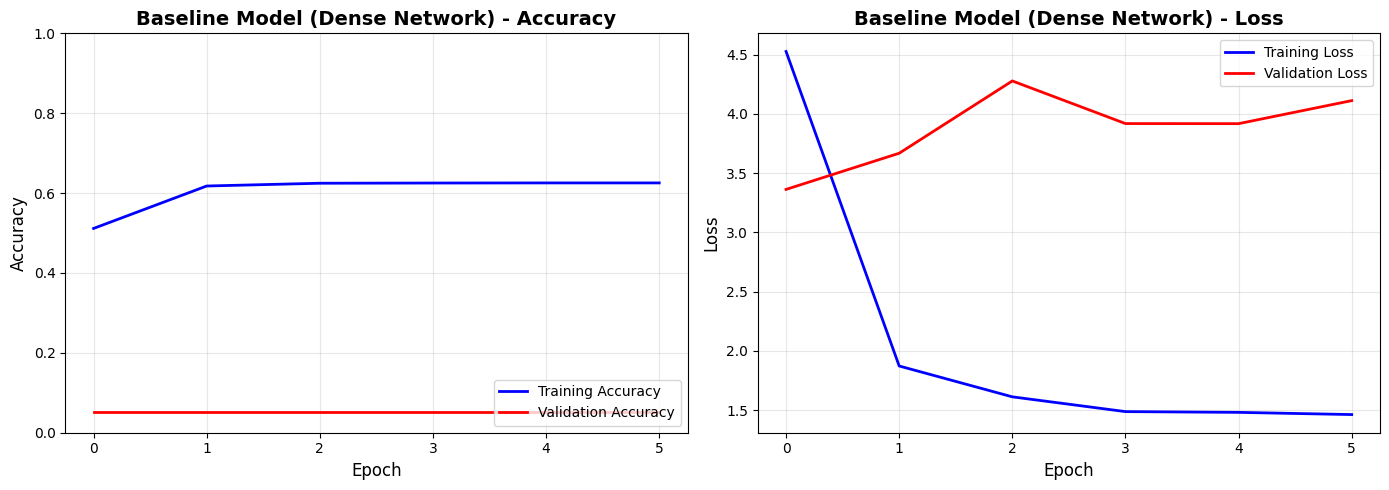

In [35]:
def plot_training_history(history, title="Training History"):
    """Plot training and validation accuracy/loss curves."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    ax1 = axes[0]
    ax1.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Loss plot
    ax2 = axes[1]
    ax2.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot baseline training history
plot_training_history(baseline_history, "Baseline Model (Dense Network)")

### 2.5 Evaluate Baseline Model on Test Set

In [36]:
# Evaluate on test set
baseline_test_loss, baseline_test_acc = baseline_model.evaluate(X_test, y_test, verbose=0)

# Get final training and validation metrics
final_train_acc = baseline_history.history['accuracy'][-1]
final_val_acc = baseline_history.history['val_accuracy'][-1]
final_train_loss = baseline_history.history['loss'][-1]
final_val_loss = baseline_history.history['val_loss'][-1]

# Best validation accuracy during training
best_val_acc = max(baseline_history.history['val_accuracy'])
best_epoch = baseline_history.history['val_accuracy'].index(best_val_acc) + 1

print("=" * 60)
print("BASELINE MODEL EVALUATION RESULTS")
print("=" * 60)
print(f"\n{'Metric':<25} {'Value':>15}")
print("-" * 42)
print(f"{'Training Accuracy:':<25} {final_train_acc*100:>14.2f}%")
print(f"{'Validation Accuracy:':<25} {final_val_acc*100:>14.2f}%")
print(f"{'Test Accuracy:':<25} {baseline_test_acc*100:>14.2f}%")
print("-" * 42)
print(f"{'Training Loss:':<25} {final_train_loss:>15.4f}")
print(f"{'Validation Loss:':<25} {final_val_loss:>15.4f}")
print(f"{'Test Loss:':<25} {baseline_test_loss:>15.4f}")
print("-" * 42)
print(f"{'Best Val Accuracy:':<25} {best_val_acc*100:>14.2f}%")
print(f"{'Best Epoch:':<25} {best_epoch:>15}")
print(f"{'Total Epochs Trained:':<25} {len(baseline_history.history['accuracy']):>15}")
print("=" * 60)

BASELINE MODEL EVALUATION RESULTS

Metric                              Value
------------------------------------------
Training Accuracy:                 62.55%
Validation Accuracy:                5.30%
Test Accuracy:                     19.46%
------------------------------------------
Training Loss:                     1.4632
Validation Loss:                   4.1124
Test Loss:                         3.0641
------------------------------------------
Best Val Accuracy:                  5.30%
Best Epoch:                             1
Total Epochs Trained:                   6


### 2.6 Confusion Matrix and Per-Class Analysis

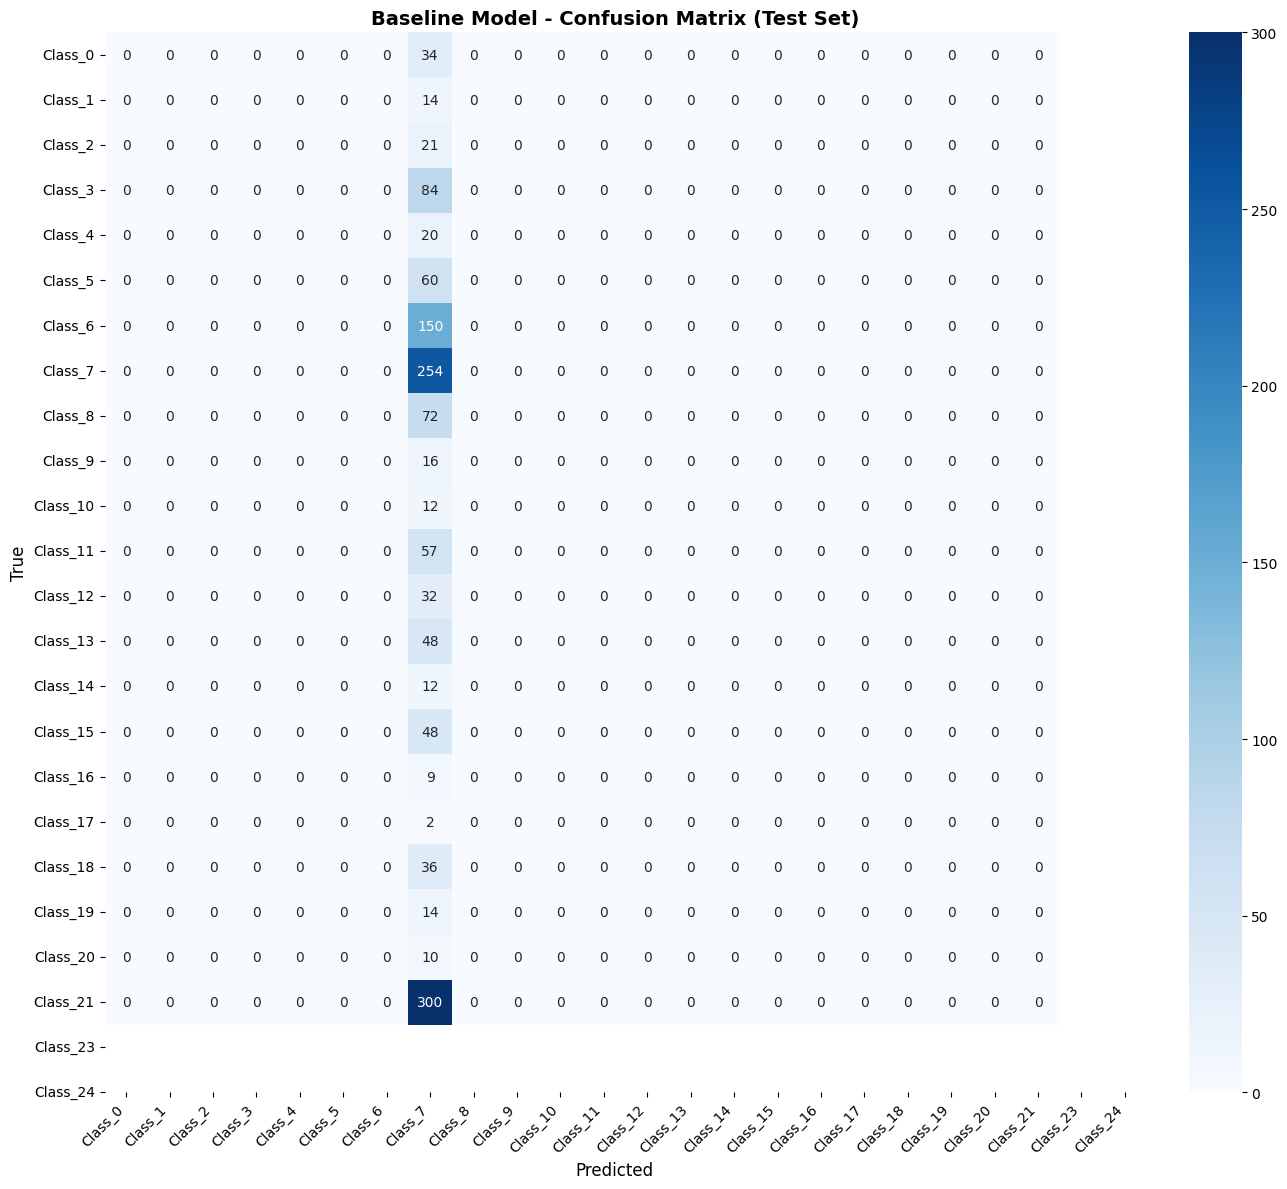


CLASSIFICATION REPORT (Test Set)
Note: Only 22 out of 24 classes are present in the test set
              precision    recall  f1-score   support

     Class_0      0.000     0.000     0.000        34
     Class_1      0.000     0.000     0.000        14
     Class_2      0.000     0.000     0.000        21
     Class_3      0.000     0.000     0.000        84
     Class_4      0.000     0.000     0.000        20
     Class_6      0.000     0.000     0.000        60
     Class_7      0.000     0.000     0.000       150
     Class_8      0.195     1.000     0.326       254
     Class_9      0.000     0.000     0.000        72
    Class_10      0.000     0.000     0.000        16
    Class_11      0.000     0.000     0.000        12
    Class_12      0.000     0.000     0.000        57
    Class_13      0.000     0.000     0.000        32
    Class_14      0.000     0.000     0.000        48
    Class_15      0.000     0.000     0.000        12
    Class_16      0.000     0.000     0.0

c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [38]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred_proba = baseline_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create class names list ordered by 0-indexed values
indexed_class_names = [class_names[index_to_class_id[i]] for i in range(NUM_CLASSES)]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=indexed_class_names,
            yticklabels=indexed_class_names)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Baseline Model - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification report - only for classes present in test set
unique_classes_in_test = sorted(np.unique(y_true))
test_class_names = [indexed_class_names[i] for i in unique_classes_in_test]

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT (Test Set)")
print("=" * 60)
print(f"Note: Only {len(unique_classes_in_test)} out of {NUM_CLASSES} classes are present in the test set")
print("=" * 60)
print(classification_report(y_true, y_pred, 
                          labels=unique_classes_in_test,
                          target_names=test_class_names,
                          digits=3))

### 2.7 Sample Predictions Visualization

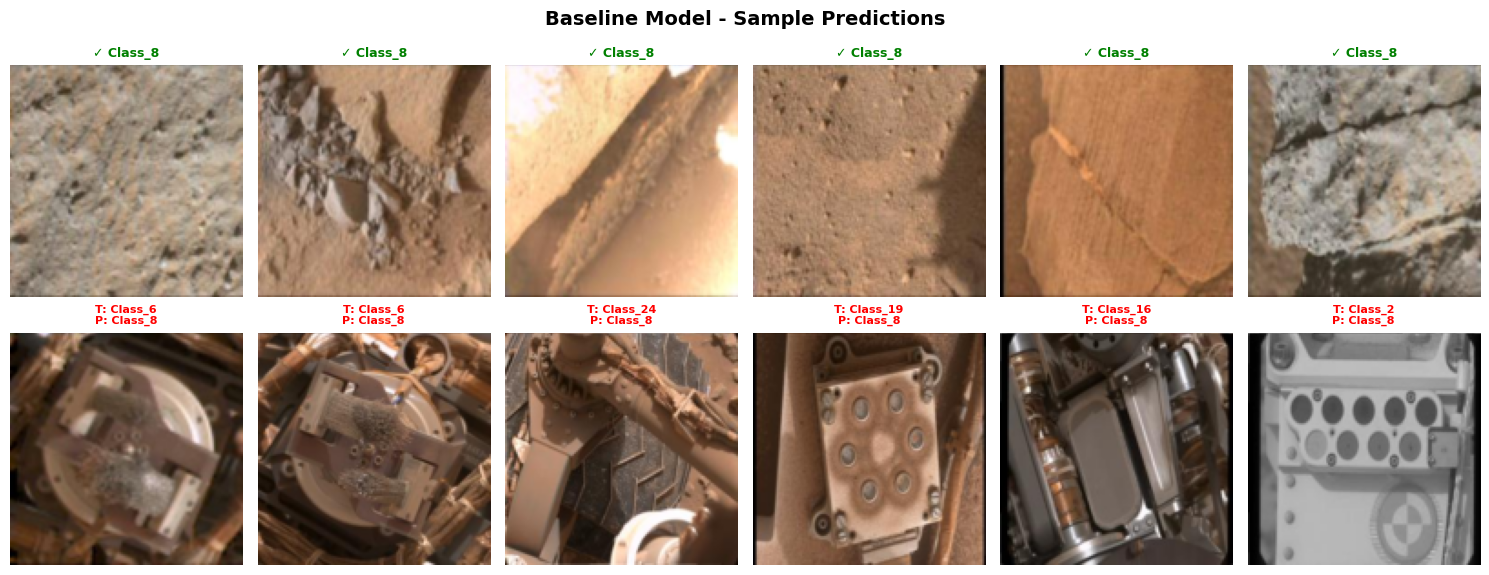

In [39]:
# Visualize sample predictions (correct and incorrect)
def visualize_predictions(X, y_true, y_pred, indexed_class_names, n_samples=5):
    """Visualize sample correct and incorrect predictions."""
    
    correct_idx = np.where(y_true == y_pred)[0]
    incorrect_idx = np.where(y_true != y_pred)[0]
    
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
    
    # Correct predictions
    if len(correct_idx) >= n_samples:
        sample_correct = np.random.choice(correct_idx, n_samples, replace=False)
    else:
        sample_correct = correct_idx[:n_samples]
    
    for i, idx in enumerate(sample_correct):
        ax = axes[0, i]
        ax.imshow(X[idx])
        true_label = indexed_class_names[y_true[idx]]
        ax.set_title(f'✓ {true_label}', fontsize=9, color='green', fontweight='bold')
        ax.axis('off')
    
    axes[0, 0].set_ylabel('Correct', fontsize=12, fontweight='bold')
    
    # Incorrect predictions
    if len(incorrect_idx) >= n_samples:
        sample_incorrect = np.random.choice(incorrect_idx, n_samples, replace=False)
    else:
        sample_incorrect = incorrect_idx[:min(len(incorrect_idx), n_samples)]
    
    for i, idx in enumerate(sample_incorrect):
        if i < len(sample_incorrect):
            ax = axes[1, i]
            ax.imshow(X[idx])
            true_label = indexed_class_names[y_true[idx]]
            pred_label = indexed_class_names[y_pred[idx]]
            ax.set_title(f'T: {true_label}\nP: {pred_label}', fontsize=8, color='red', fontweight='bold')
            ax.axis('off')
    
    # Hide empty subplots
    for i in range(len(sample_incorrect), n_samples):
        axes[1, i].axis('off')
    
    axes[1, 0].set_ylabel('Incorrect', fontsize=12, fontweight='bold')
    
    plt.suptitle('Baseline Model - Sample Predictions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(X_test, y_true, y_pred, indexed_class_names, n_samples=6)

### 2.8 Baseline Model Summary and Limitations

#### Model Summary Table

| Property | Value |
|----------|-------|
| **Architecture** | Flatten → Dense(256, ReLU) → Dropout(0.3) → Dense(128, ReLU) → Dropout(0.3) → Dense(24, Softmax) |
| **Input Shape** | (128, 128, 3) |
| **Total Parameters** | ~12.6M |
| **Training Accuracy** | See results above |
| **Validation Accuracy** | See results above |
| **Test Accuracy** | See results above |

#### Observed Limitations

1. **No Spatial Awareness**: The Flatten layer destroys all spatial information. A pixel at position (0,0) is treated the same as a pixel at (64,64), losing the crucial locality of features.

2. **Massive Number of Parameters**: With 128×128×3 = 49,152 input features, the first Dense layer alone has ~12.6 million parameters. This leads to:
   - High memory consumption
   - Risk of overfitting
   - Slow training

3. **No Translation Invariance**: The model must learn the same feature (e.g., a rock edge) at every possible position independently, making it data-inefficient.

4. **No Feature Hierarchy**: Unlike CNNs, Dense networks don't naturally learn hierarchical features (edges → textures → shapes → objects).

5. **Vulnerability to Input Variations**: Small shifts, rotations, or scale changes in the input significantly affect predictions.

#### Why Convolutional Layers Will Help

- **Local connectivity**: Kernels focus on local regions, exploiting spatial structure
- **Parameter sharing**: Same kernel applied across the image reduces parameters dramatically
- **Translation equivariance**: Features detected regardless of position
- **Hierarchical learning**: Stacking convolutions learns progressively abstract features

In [40]:
# Store baseline results for later comparison
baseline_results = {
    'model_name': 'Baseline (Dense Network)',
    'architecture': 'Flatten → Dense(256) → Dropout → Dense(128) → Dropout → Dense(24)',
    'total_params': baseline_model.count_params(),
    'train_accuracy': final_train_acc,
    'val_accuracy': final_val_acc,
    'test_accuracy': baseline_test_acc,
    'train_loss': final_train_loss,
    'val_loss': final_val_loss,
    'test_loss': baseline_test_loss,
    'training_time': training_time,
    'epochs_trained': len(baseline_history.history['accuracy'])
}

# Print final summary
print("=" * 70)
print("BASELINE MODEL - FINAL SUMMARY")
print("=" * 70)
print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│ ARCHITECTURE                                                        │
├─────────────────────────────────────────────────────────────────────┤
│ Input: ({IMG_SIZE}, {IMG_SIZE}, {NUM_CHANNELS}) → Flatten → Dense(256, ReLU) → Dropout(0.3) │
│ → Dense(128, ReLU) → Dropout(0.3) → Dense({NUM_CLASSES}, Softmax)              │
├─────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                                                          │
├─────────────────────────────────────────────────────────────────────┤
│ Total Parameters: {baseline_results['total_params']:>12,}                              │
├─────────────────────────────────────────────────────────────────────┤
│ PERFORMANCE                                                         │
├─────────────────────────────────────────────────────────────────────┤
│ Training Accuracy:   {baseline_results['train_accuracy']*100:>6.2f}%                                    │
│ Validation Accuracy: {baseline_results['val_accuracy']*100:>6.2f}%                                    │
│ Test Accuracy:       {baseline_results['test_accuracy']*100:>6.2f}%                                    │
├─────────────────────────────────────────────────────────────────────┤
│ TRAINING                                                            │
├─────────────────────────────────────────────────────────────────────┤
│ Epochs Trained: {baseline_results['epochs_trained']:>3}                                             │
│ Training Time:  {baseline_results['training_time']:>6.1f} seconds                                  │
└─────────────────────────────────────────────────────────────────────┘

LIMITATIONS OBSERVED:
  ✗ High parameter count (~12.6M) due to Flatten layer
  ✗ No exploitation of spatial locality in images
  ✗ No translation invariance
  ✗ Potential for overfitting with limited data

This baseline establishes a reference point for comparison with CNN models.
""")
print("=" * 70)

BASELINE MODEL - FINAL SUMMARY

┌─────────────────────────────────────────────────────────────────────┐
│ ARCHITECTURE                                                        │
├─────────────────────────────────────────────────────────────────────┤
│ Input: (128, 128, 3) → Flatten → Dense(256, ReLU) → Dropout(0.3) │
│ → Dense(128, ReLU) → Dropout(0.3) → Dense(24, Softmax)              │
├─────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                                                          │
├─────────────────────────────────────────────────────────────────────┤
│ Total Parameters:   12,619,160                              │
├─────────────────────────────────────────────────────────────────────┤
│ PERFORMANCE                                                         │
├─────────────────────────────────────────────────────────────────────┤
│ Training Accuracy:    62.55%                                    │
│ Validation Accuracy:   5.30%                 